# Tutorial 05 - Features
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/schedldave/cv2021/blob/main/04_Edges.ipynb)
## Dr. David C. Schedl

Note: this tutorial is geared towards students **experienced in programming** and aims to introduce you to **Computer Vision** techniques.


Useful links:
* OpenCV Tutorials: https://docs.opencv.org/master/d9/df8/tutorial_root.html
* Image Processing in Pyhton: https://github.com/xn2333/OpenCV/blob/master/Seminar_Image_Processing_in_Python.ipynb



# Table of Contents  

- Initialization
- Harris Corner Detector
- Histograms
- SIFT Features

<a id="Initialization"></a>

# Initialization

As always let's import useful libraries, first. 
We will work with images today. So let's download some with `curl`.
Let's define utility functions to display images, in Jupyter Notebooks. OpenCV's `imshow` does not work and matplotlib's `imshow` needs special treatment due to color channel handling (RGB vs. BGR)

In [2]:
import os
import cv2 # openCV
import numpy as np
import matplotlib.pyplot as plt

 
# loading images
#!curl -o "cat.jpg" "https://placekitten.com/256/256"
#!curl -o "gogh.jpg" "https://upload.wikimedia.org/wikipedia/commons/thumb/3/32/Vincent_van_Gogh_-_National_Gallery_of_Art.JPG/367px-Vincent_van_Gogh_-_National_Gallery_of_Art.JPG"
#!curl -o "einstein.jpg" "https://www.cns.nyu.edu/~lcv/ssim/index_files/image003.jpg"
# !curl -o "woman.jpg" "https://live.staticflickr.com/8859/18045025168_3a1ffa6521_w_d.jpg"
!curl -o "woman.jpg" "https://live.staticflickr.com/8859/18045025168_3a1ffa6521_c_d.jpg"
!curl -o "foto1A.jpg" "https://www.ic.unicamp.br/~helio/imagens_registro/foto1A.jpg"
!curl -o "foto1B.jpg" "https://www.ic.unicamp.br/~helio/imagens_registro/foto1B.jpg"

# utility function(s)
def imshow(image, *args, **kwargs):
    """A replacement for cv2.imshow() for use in Jupyter notebooks using matplotlib.

        Args:
          image : np.ndarray. shape (N, M) or (N, M, 1) is an NxM grayscale image. shape
            (N, M, 3) is an NxM BGR color image. 
    """
    if len(image.shape) == 3:
      # Height, width, channels
      # Assume BGR, do a conversion  
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Draw the image
    plt.imshow(image, *args, **kwargs)
    # We'll also disable drawing the axes and tick marks in the plot, since it's actually an image
    plt.axis('off')
    # Make sure it outputs
    # plt.show()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 56921    0 56921    0     0  56921      0 --:--:-- --:--:-- --:--:--  703k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0  161k    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100  161k  100  161k    0     0   161k      0  0:00:01  0:00:01 --:--:-- 95328
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:

# Harris Corner Detector


## OpenCV's Harris implementation

Let's first look at the implementation available with OpenCV. 
```
cv2.cornerHarris(src, blockSize, ksize, k)
```
The `cornerHarris` function takes an image, the window size, a size parameter for the Sobel operator and k, the Harris detector free parameter, as input.
Let's apply it to our example image.

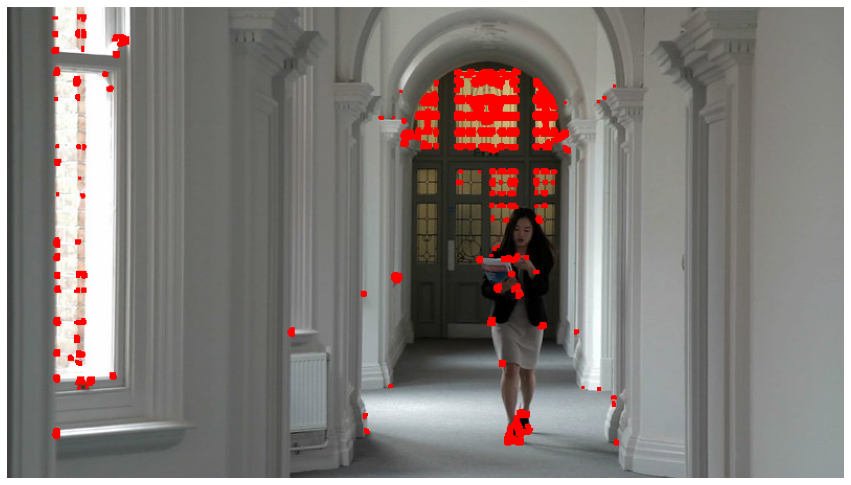

In [2]:
filename = "woman.jpg"
img = cv2.imread(filename)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

dst = cv2.cornerHarris(gray.astype(np.float32),5,3,0.04)

#result is dilated for marking the corners, not important
dst = cv2.dilate(dst,None)

# Threshold for an optimal value, it may vary depending on the image.
img[dst>0.01*dst.max()]=[0,0,255]


plt.figure(figsize=(15,10))
imshow(img)
plt.show()


## Non-OpenCV implementation

To understand the algorithm better let's also look at an implementation without the builtin function of OpenCV. This implementation can also be found [online](https://github.com/hughesj919/HarrisCorner/blob/master/Corners.py). 
Note: the implementation is not very optimized and just for illustration. 
A local maximum suppression of R is not used.
Furthermore, it allows us to look at the computed R.

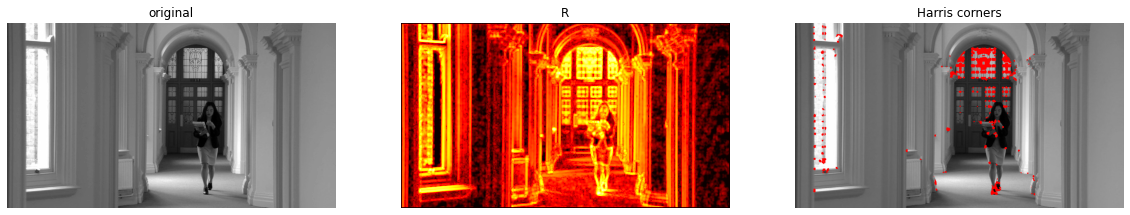

In [3]:
def findCorners(img, window_size=5, k=0.04, thresh=10000 ):
    """
    Finds and returns list of corners and new image with corners drawn
    :param img: The original image
    :param window_size: The size (side length) of the sliding window
    :param k: Harris corner constant. Usually 0.04 - 0.06
    :param thresh: The threshold above which a corner is counted
    :return:
    """
    #Find x and y derivatives
    dy, dx = np.gradient(img)
    Ixx = dx**2
    Ixy = dy*dx
    Iyy = dy**2
    height = img.shape[0]
    width = img.shape[1]

    cornerList = []
    newImg = img.copy()
    color_img = cv2.cvtColor(newImg, cv2.COLOR_GRAY2RGB)
    offset = int(window_size/2)
    R = np.zeros_like(dx)

    #Loop through image and find our corners
    for y in range(offset, height-offset):
        for x in range(offset, width-offset):
            #Calculate sum of squares
            windowIxx = Ixx[y-offset:y+offset+1, x-offset:x+offset+1]
            windowIxy = Ixy[y-offset:y+offset+1, x-offset:x+offset+1]
            windowIyy = Iyy[y-offset:y+offset+1, x-offset:x+offset+1]
            Sxx = windowIxx.sum()
            Sxy = windowIxy.sum()
            Syy = windowIyy.sum()

            #Find determinant and trace, use to get corner response
            det = (Sxx * Syy) - (Sxy**2)
            trace = Sxx + Syy
            r = det - k*(trace**2)

            R[y,x] = r # store in R matrix

            #If corner response is over threshold, color the point and add to corner list
            if r > thresh:
                #print x, y, r
                cornerList.append([x, y, r])
                color_img.itemset((y, x, 0), 0)
                color_img.itemset((y, x, 1), 0)
                color_img.itemset((y, x, 2), 255)
    return color_img, R, cornerList


finalImg, R, cornerList = findCorners(gray, 5, 0.05, thresh=10000000)

# plotting
plt.figure(figsize=(20,15))
plt.subplot(131), imshow(gray, cmap='gray'), plt.title( 'original' )
plt.subplot(132), imshow(np.log(abs(R)+1.0), cmap='hot'), plt.title( 'R' )
plt.subplot(133),imshow(finalImg), plt.title( 'Harris corners' ) 
plt.show()




# Histograms

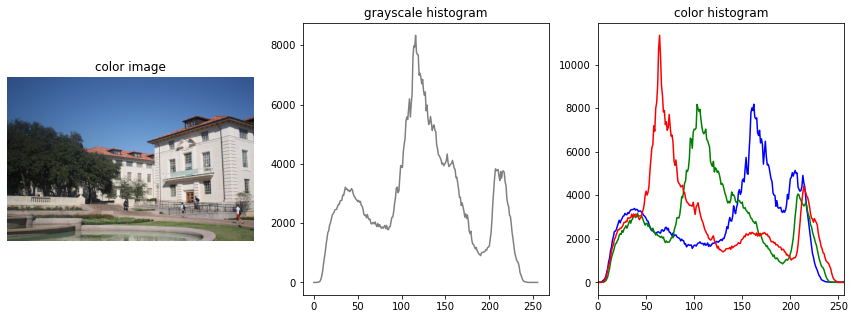

In [3]:
img = cv2.imread('foto1A.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # convert to grayscale

color = ('b','g','r')
plt.figure(figsize=(15,5)) # this command makes the figure larger so we see the images better
plt.subplot(131), imshow(img, cmap="gray"), plt.title('color image')
plt.subplot(132), plt.title('grayscale histogram')
histr = cv2.calcHist([gray],[0],None,[256],[0,256])
plt.plot(histr,color = 'gray')
plt.subplot(133), plt.title('color histogram')
for i,col in enumerate(color):
    histr = cv2.calcHist([img],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])

plt.show()

## ⌨️ Try it yourself: Implement your own (grayscale) histogram function

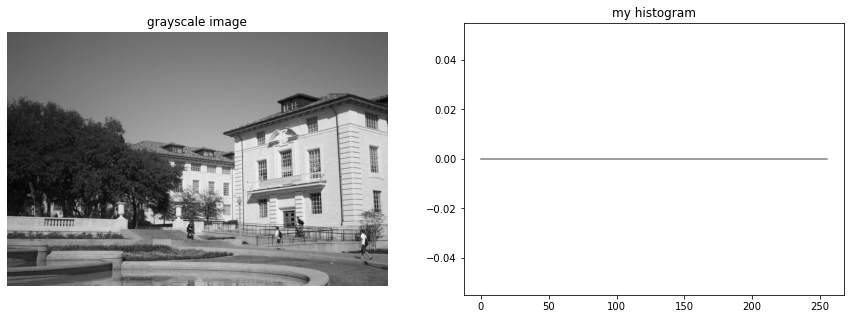

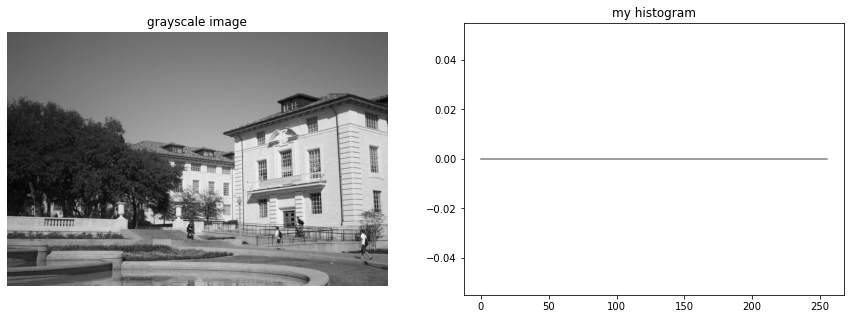

In [4]:
def compute_hist( gray ):
    assert len(gray.shape)==2 # make sure it is 2D and grayscale
    bins = np.zeros((256))

    # Todo

    return bins


# test it!
plt.figure(figsize=(15,5)) # this command makes the figure larger so we see the images better
plt.subplot(121), imshow(gray, cmap="gray"), plt.title('grayscale image')
plt.subplot(122), plt.title('my histogram')
my_histr = compute_hist(gray)
plt.plot(my_histr,color = 'gray')
plt.show()

# test it!
plt.figure(figsize=(15,5)) # this command makes the figure larger so we see the images better
plt.subplot(121), imshow(gray, cmap="gray"), plt.title('grayscale image')
plt.subplot(122), plt.title('my histogram')
my_histr = compute_hist(gray)
plt.plot(my_histr,color = 'gray')
plt.show()

# SIFT Features

In [5]:
# select the image id (valid values 1,2,3, or 4)
feature_extractor = 'orb' # one of 'sift', 'surf', 'brisk', 'orb'
feature_matching = 'bf'

## ReadME

- When choosing the images bellow, make sure that the **train image** is the image to be transformed. 

- For the images in the input folder, the image with id 3 should be inverted so that **train image** is the image B and **query image** is the image A.

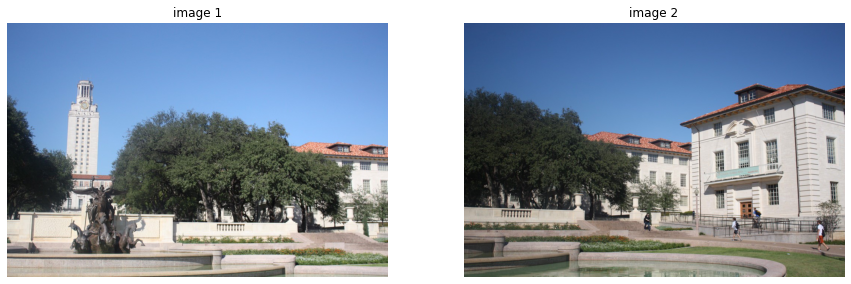

In [6]:
# read images and transform them to grayscale
# Make sure that the train image is the image that will be transformed

def load_images():
    !curl -o "foto1A.jpg" "https://www.ic.unicamp.br/~helio/imagens_registro/foto1A.jpg"
    !curl -o "foto1B.jpg" "https://www.ic.unicamp.br/~helio/imagens_registro/foto1B.jpg"

try:
    trainImg = cv2.imread("foto1A.jpg")
    queryImg = cv2.imread("foto1B.jpg")
except:
    trainImg, queryImg = None, None

if trainImg is None or queryImg is None:
    load_images()
    trainImg = cv2.imread("foto1A.jpg")
    queryImg = cv2.imread("foto1B.jpg")

# convert to grayscale
trainImg_gray = cv2.cvtColor(trainImg, cv2.COLOR_RGB2GRAY)
queryImg_gray = cv2.cvtColor(queryImg, cv2.COLOR_RGB2GRAY)



plt.figure(figsize=(15,10)) # this command makes the figure larger so we see the images better
plt.subplot(121), imshow(queryImg, cmap="gray"), plt.title('image 1')
plt.subplot(122), imshow(trainImg, cmap="gray"), plt.title('image 2')

plt.show()

In [7]:
def detectAndDescribe(image, method=None):
    """
    Compute key points and feature descriptors using an specific method
    """
    
    assert method is not None, "You need to define a feature detection method. Values are: 'sift', 'surf'"
    
    # detect and extract features from the image
    if method == 'sift':
        descriptor = cv2.xfeatures2d.SIFT_create()
    elif method == 'surf':
        descriptor = cv2.xfeatures2d.SURF_create()
    elif method == 'brisk':
        descriptor = cv2.BRISK_create()
    elif method == 'orb':
        descriptor = cv2.ORB_create()
        
    # get keypoints and descriptors
    (kps, features) = descriptor.detectAndCompute(image, None)
    
    return (kps, features)

In [8]:
kpsA, featuresA = detectAndDescribe(trainImg_gray, method=feature_extractor)
kpsB, featuresB = detectAndDescribe(queryImg_gray, method=feature_extractor)

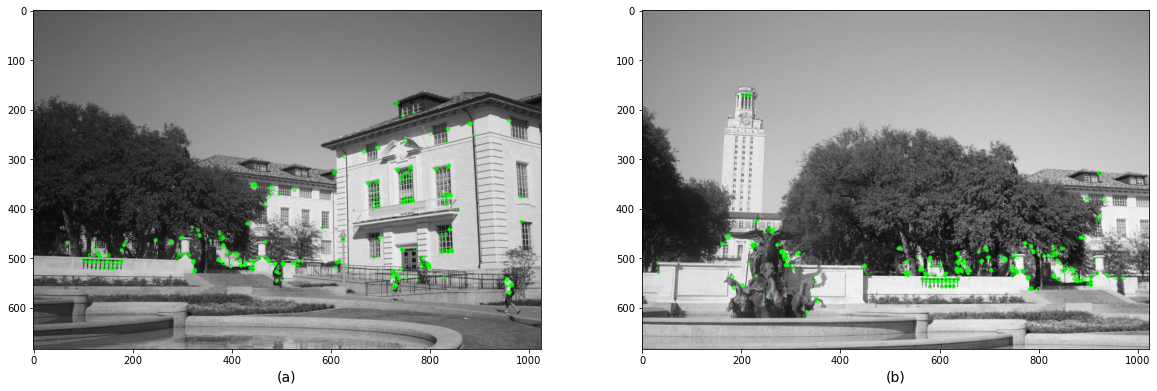

In [9]:
# display the keypoints and features detected on both images
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8), constrained_layout=False)
ax1.imshow(cv2.drawKeypoints(trainImg_gray,kpsA,None,color=(0,255,0)))
ax1.set_xlabel("(a)", fontsize=14)
ax2.imshow(cv2.drawKeypoints(queryImg_gray,kpsB,None,color=(0,255,0)))
ax2.set_xlabel("(b)", fontsize=14)

plt.show()

In [10]:
def createMatcher(method,crossCheck):
    "Create and return a Matcher Object"
    
    if method == 'sift' or method == 'surf':
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=crossCheck)
    elif method == 'orb' or method == 'brisk':
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=crossCheck)
    return bf

In [11]:
def matchKeyPointsBF(featuresA, featuresB, method):
    bf = createMatcher(method, crossCheck=True)
        
    # Match descriptors.
    best_matches = bf.match(featuresA,featuresB)
    
    # Sort the features in order of distance.
    # The points with small distance (more similarity) are ordered first in the vector
    rawMatches = sorted(best_matches, key = lambda x:x.distance)
    print("Raw matches (Brute force):", len(rawMatches))
    return rawMatches

In [12]:
def matchKeyPointsKNN(featuresA, featuresB, ratio, method):
    bf = createMatcher(method, crossCheck=False)
    # compute the raw matches and initialize the list of actual matches
    rawMatches = bf.knnMatch(featuresA, featuresB, 2)
    print("Raw matches (knn):", len(rawMatches))
    matches = []

    # loop over the raw matches
    for m,n in rawMatches:
        # ensure the distance is within a certain ratio of each
        # other (i.e. Lowe's ratio test)
        if m.distance < n.distance * ratio:
            matches.append(m)
    return matches

Using: bf feature matcher
Raw matches (Brute force): 189


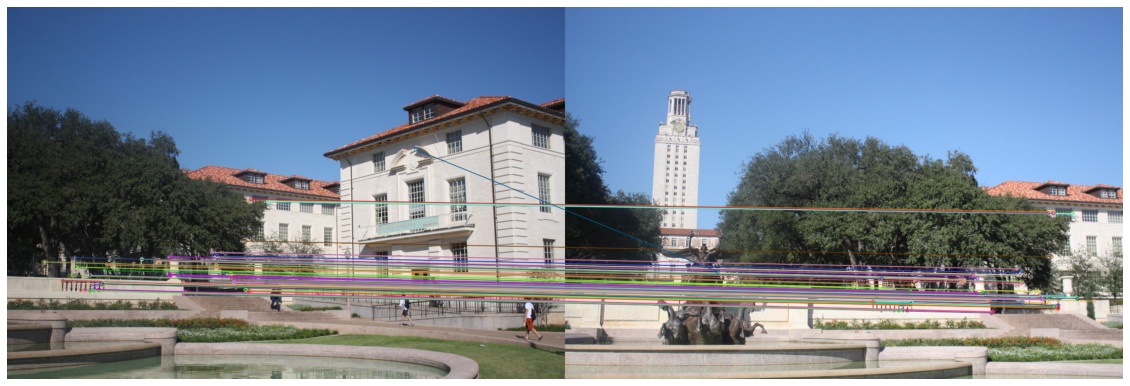

In [13]:
print("Using: {} feature matcher".format(feature_matching))

fig = plt.figure(figsize=(20,8))

if feature_matching == 'bf':
    matches = matchKeyPointsBF(featuresA, featuresB, method=feature_extractor)
    img3 = cv2.drawMatches(trainImg,kpsA,queryImg,kpsB,matches[:100],
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
elif feature_matching == 'knn':
    matches = matchKeyPointsKNN(featuresA, featuresB, ratio=0.75, method=feature_extractor)
    img3 = cv2.drawMatches(trainImg,kpsA,queryImg,kpsB,np.random.choice(matches,100),
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    

imshow(img3)
plt.show()

In [14]:
def getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh):
    # convert the keypoints to numpy arrays
    kpsA = np.float32([kp.pt for kp in kpsA])
    kpsB = np.float32([kp.pt for kp in kpsB])
    
    if len(matches) > 4:

        # construct the two sets of points
        ptsA = np.float32([kpsA[m.queryIdx] for m in matches])
        ptsB = np.float32([kpsB[m.trainIdx] for m in matches])
        
        # estimate the homography between the sets of points
        (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,
            reprojThresh)

        return (matches, H, status)
    else:
        return None

In [15]:
M = getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh=4)
if M is None:
    print("Error!")
(matches, H, status) = M
print(H)

[[ 8.10724931e-01  1.15352088e-01  4.26531758e+02]
 [-1.35248937e-01  9.99663475e-01  5.53473580e+01]
 [-2.10701697e-04  5.38267578e-05  1.00000000e+00]]


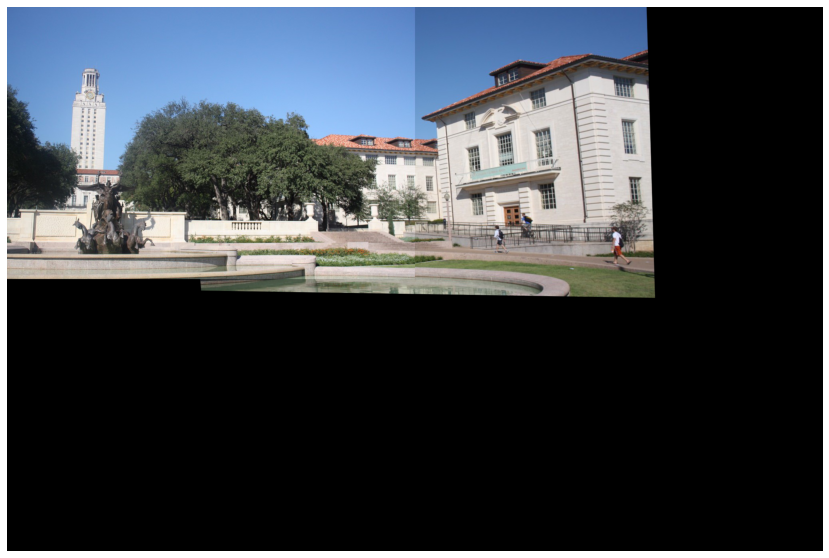

In [16]:
# Apply panorama correction
width = trainImg.shape[1] + queryImg.shape[1]
height = trainImg.shape[0] + queryImg.shape[0]

result = cv2.warpPerspective(trainImg, H, (width, height))
result[0:queryImg.shape[0], 0:queryImg.shape[1]] = queryImg

plt.figure(figsize=(20,10))
imshow(result)

plt.axis('off')
plt.show()

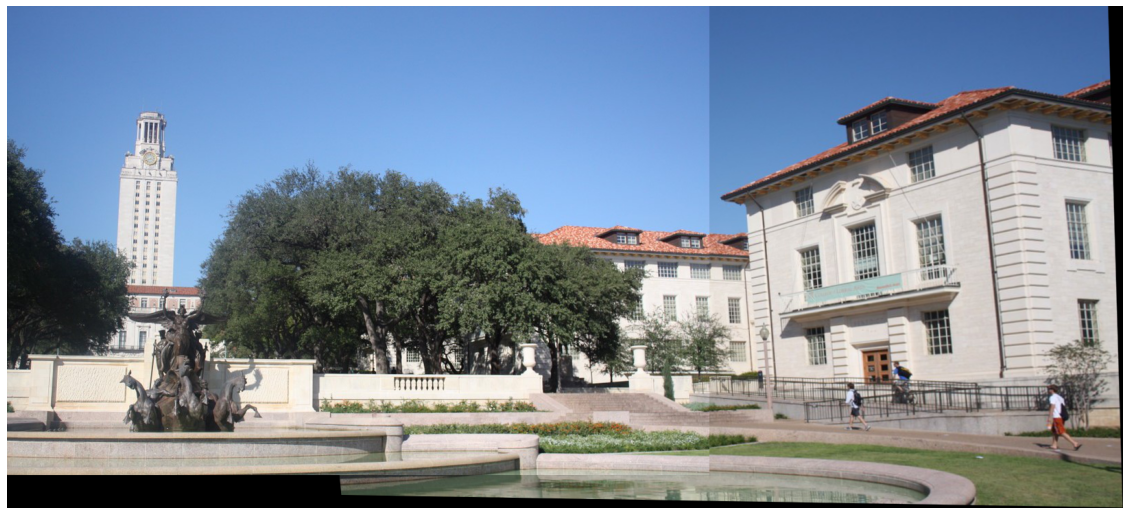

In [17]:
# transform the panorama image to grayscale and threshold it 
gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]

# Finds contours from the binary image
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# get the maximum contour area
c = max(cnts[0], key=cv2.contourArea)

# get a bbox from the contour area
(x, y, w, h) = cv2.boundingRect(c)

# crop the image to the bbox coordinates
result = result[y:y + h, x:x + w]

# show the cropped image
plt.figure(figsize=(20,10))
imshow(result)

[INFO] stitching images...


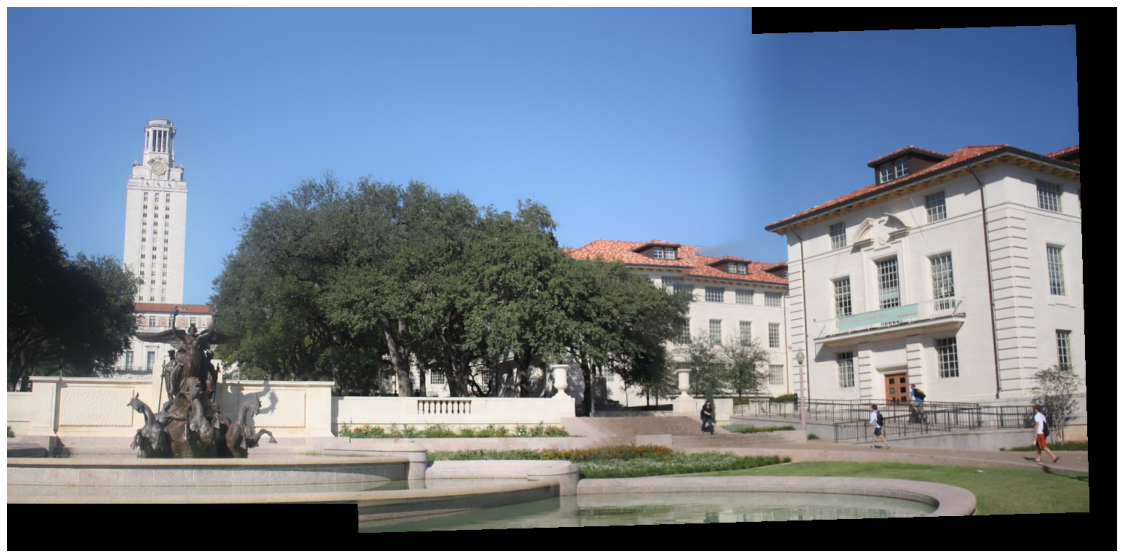

In [18]:
# initialize OpenCV's image stitcher object and then perform the image
# stitching
images = [queryImg, trainImg]
print("[INFO] stitching images...")
stitcher = cv2.Stitcher_create( mode=1 ) # mode=0 is panorama and assumes spherical stitichg, mode=1 is scan
(status, stitched) = stitcher.stitch(images)

if status==0:
  plt.figure(figsize=(20,10))
  imshow(stitched)